In [7]:
from pathlib import Path
import os
from tqdm import tqdm
import pickle
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D

2.17.1


## Preprocessing the annotations file

In [ ]:
annot_cols = ['img_name', 'x1', 'y1', 'x2', 'y2', 'img_class']

train_annot = pd.read_csv('/content/drive/MyDrive/Car Images/Train+Annotations.csv', skiprows=1, names=annot_cols)
test_annot  = pd.read_csv('/content/drive/MyDrive/Car Images/Test+Annotation.csv', skiprows=1, names=annot_cols)

print('Shape of Train annot is : ', train_annot.shape)
print('Shape of Test annot is  : ', test_annot.shape)

In [ ]:
train_annot.head()

In [ ]:
train_folder_path = Path('/content/drive/MyDrive/Car Images/Train Images')
train_file_path = pd.DataFrame(list(train_folder_path.glob('*/*.jpg')), columns=['file_path'])
train_file_path['file_path'] = train_file_path['file_path'].astype('str')
train_file_path['base_name'] = train_file_path['file_path'].apply(lambda x : os.path.basename(x))
train_file_path['class_name'] = train_file_path['file_path'].apply(lambda x : x.split('/')[-2])

test_folder_path = Path('/content/drive/MyDrive/Car Images/Test Images')
test_file_path = pd.DataFrame(list(test_folder_path.glob('*/*.jpg')), columns=['file_path'])
test_file_path['file_path'] = test_file_path['file_path'].astype('str')
test_file_path['base_name'] = test_file_path['file_path'].apply(lambda x : os.path.basename(x))
test_file_path['class_name'] = test_file_path['file_path'].apply(lambda x : x.split('/')[-2])

print("Train : ", train_file_path.shape)
print("Test  :", test_file_path.shape)

train_file_path.sample(5)

In [ ]:
train_images = []
train_height = []
train_width = []

for path in train_file_path['file_path'].values:
    img_array = cv2.imread(path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    h, w, _ = img_array.shape
    img_array_resize = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
    train_images.append(img_array_resize)
    train_height.append(h)
    train_width.append(w)

In [ ]:
np.save('/content/drive/MyDrive/Car Images/temp_files/train_images_array.npy', np.array(train_images))

In [ ]:
train_file_path['height'] = train_height
train_file_path['width'] = train_width

In [ ]:
test_images = []
test_height = []
test_width = []

for path in test_file_path['file_path'].values:
    img_array = cv2.imread(path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    h, w, _ = img_array.shape
    img_array_resize = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
    test_images.append(img_array_resize)
    test_height.append(h)
    test_width.append(w)

In [ ]:
np.save('/content/drive/MyDrive/Car Images/temp_files/test_images_array.npy', np.array(test_images))

In [ ]:
test_file_path['height'] = test_height
test_file_path['width'] = test_width

In [ ]:
train_images.shape, test_images.shape

((8144, 224, 224, 3), (8041, 224, 224, 3))

In [ ]:
train_merge = pd.merge(train_annot, train_file_path, left_on='img_name', right_on='base_name')
test_merge = pd.merge(test_annot, test_file_path, left_on='img_name', right_on='base_name')

train_merge.sample(5)

In [ ]:
# converting classes from 1-196 to 0-195
train_merge['img_class'] = train_merge['img_class'] - 1
test_merge['img_class'] = test_merge['img_class'] - 1

In [ ]:
train_merge.drop(['base_name', 'img_name'], axis=1, inplace=True)
test_merge.drop(['base_name', 'img_name'], axis=1, inplace=True)

train_merge.sample(5)

In [ ]:
! mkdir '/content/drive/MyDrive/Car Images/processed_outputs'

train_merge.to_csv('/content/drive/MyDrive/Car Images/processed_outputs/train_processed.csv', index=False)
test_merge.to_csv('/content/drive/MyDrive/Car Images/processed_outputs/test_processed.csv', index=False)

## Loading processed annotations file

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Car Images/processed_outputs/train_processed.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Car Images/processed_outputs/test_processed.csv')

In [ ]:
train_bbox = train_data[['x1', 'y1', 'x2', 'y2']].values
test_bbox = test_data[['x1', 'y1', 'x2', 'y2']].values

In [ ]:
class_names = dict(train_data[['img_class', 'class_name']].value_counts().sort_index().index.to_list())
class_names

{0: 'AM General Hummer SUV 2000',
 1: 'Acura RL Sedan 2012',
 2: 'Acura TL Sedan 2012',
 3: 'Acura TL Type-S 2008',
 4: 'Acura TSX Sedan 2012',
 5: 'Acura Integra Type R 2001',
 6: 'Acura ZDX Hatchback 2012',
 7: 'Aston Martin V8 Vantage Convertible 2012',
 8: 'Aston Martin V8 Vantage Coupe 2012',
 9: 'Aston Martin Virage Convertible 2012',
 10: 'Aston Martin Virage Coupe 2012',
 11: 'Audi RS 4 Convertible 2008',
 12: 'Audi A5 Coupe 2012',
 13: 'Audi TTS Coupe 2012',
 14: 'Audi R8 Coupe 2012',
 15: 'Audi V8 Sedan 1994',
 16: 'Audi 100 Sedan 1994',
 17: 'Audi 100 Wagon 1994',
 18: 'Audi TT Hatchback 2011',
 19: 'Audi S6 Sedan 2011',
 20: 'Audi S5 Convertible 2012',
 21: 'Audi S5 Coupe 2012',
 22: 'Audi S4 Sedan 2012',
 23: 'Audi S4 Sedan 2007',
 24: 'Audi TT RS Coupe 2012',
 25: 'BMW ActiveHybrid 5 Sedan 2012',
 26: 'BMW 1 Series Convertible 2012',
 27: 'BMW 1 Series Coupe 2012',
 28: 'BMW 3 Series Sedan 2012',
 29: 'BMW 3 Series Wagon 2012',
 30: 'BMW 6 Series Convertible 2007',
 31: '

## Display images with bounding box

File Name    : 01001.jpg
Car Name     : Bentley Continental GT Coupe 2007
Label        : 43
Image height : 370
Image width  : 625


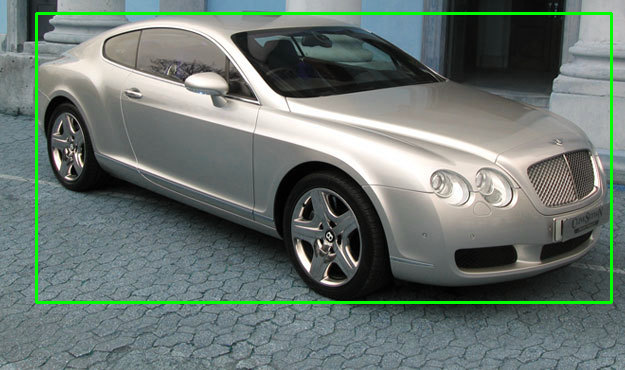

In [ ]:
# checking a sample image and its label

i = 1000

img_to_show = cv2.imread(train_merge['file_path'][i])

# plt.rcParams['figure.figsize']=(8,8)

print('File Name    :', train_merge['img_name'][i])
print('Car Name     :', train_merge['class_name'][i])
print('Label        :', train_merge['img_class'][i])
print('Image height :', img_to_show.shape[0])
print('Image width  :', img_to_show.shape[1])

cv2.rectangle(img_to_show,(train_merge['x1'][i],train_merge['y1'][i]),(train_merge['x2'][i],train_merge['y2'][i]),(0,255,0),2)

cv2_imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))

File Name    : 01001.jpg
Car Name     : Bentley Continental GT Coupe 2007
Label        : 43
Image height : 224
Image width  : 224


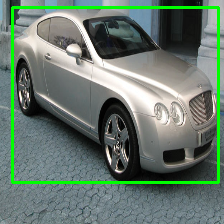

In [ ]:
# checking a sample image and its label

i = 1000

img_to_show = cv2.imread(train_merge['file_path'][i])
img_to_show_resize = cv2.resize(img_to_show,(224,224))

resize_factor_height = 224/img_to_show.shape[0]
resize_factor_width = 224/img_to_show.shape[1]

# plt.rcParams['figure.figsize']=(8,8)

print('File Name    :', train_merge['img_name'][i])
print('Car Name     :', train_merge['class_name'][i])
print('Label        :', train_merge['img_class'][i])
print('Image height :', img_to_show_resize.shape[0])
print('Image width  :', img_to_show_resize.shape[1])


cv2.rectangle(img_to_show_resize,(int(train_merge['x1'][i]*resize_factor_width), int(train_merge['y1'][i]*resize_factor_height)),
              (int(train_merge['x2'][i]*resize_factor_width), int(train_merge['y2'][i]*resize_factor_height) ),
              (0,255,0),2)

cv2_imshow(cv2.cvtColor(img_to_show_resize, cv2.COLOR_BGR2RGB))

Sample Train images with their bounding box



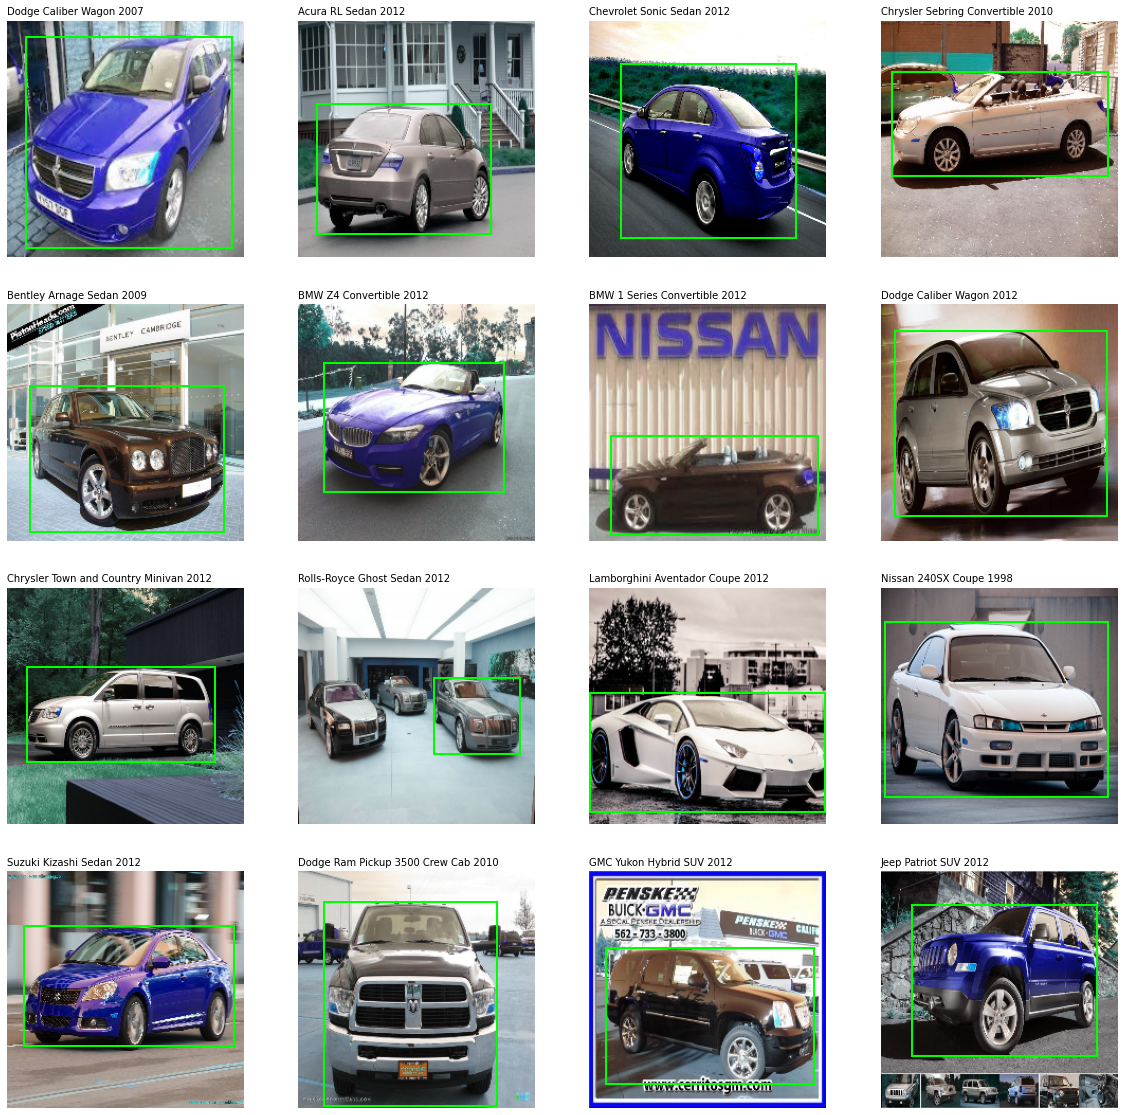

In [ ]:
print('Sample Train images with their bounding box\n')

plt.figure(figsize=(20, 20))

for i, (images, labels, x1, y1, x2, y2) in enumerate(train_merge[['file_path', 'class_name','x1','y1','x2','y2']].sample(16).values):
    ax = plt.subplot(4, 4, i + 1)
    img = cv2.imread(images)
    img_resize = cv2.resize(img, (224,224))

    resize_factor_height = 224/img.shape[0]
    resize_factor_width = 224/img.shape[1]

    plt.imshow(img_resize)
    rect = patches.Rectangle((int(x1*resize_factor_width), int(y1*resize_factor_height)),
              int((x2-x1)*resize_factor_width), int((y2-y1)*resize_factor_height),
              linewidth=2, edgecolor='lime', facecolor='none')


    plt.title(labels, loc='left', fontsize=10)
    ax.add_patch(rect)
    plt.axis("off")

Sample Test images with their bounding box



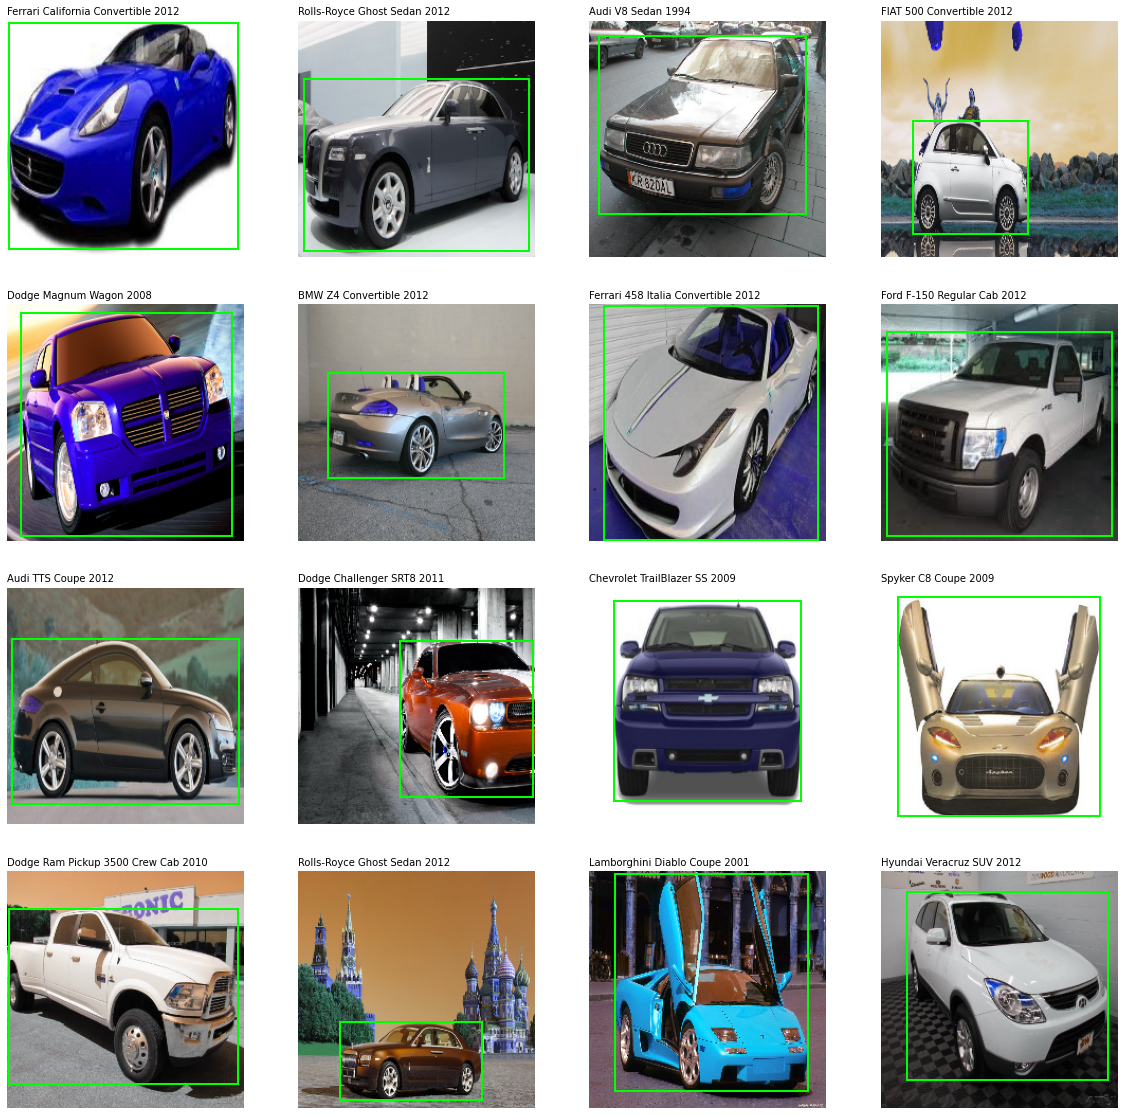

In [ ]:
print('Sample Test images with their bounding box\n')

plt.figure(figsize=(20, 20))

for i, (images, labels, x1, y1, x2, y2) in enumerate(test_merge[['file_path', 'class_name','x1','y1','x2','y2']].sample(16).values):
    ax = plt.subplot(4, 4, i + 1)
    img = cv2.imread(images)
    img_resize = cv2.resize(img, (224,224))

    resize_factor_height = 224/img.shape[0]
    resize_factor_width = 224/img.shape[1]

    plt.imshow(img_resize)
    rect = patches.Rectangle((int(x1*resize_factor_width), int(y1*resize_factor_height)),
              int((x2-x1)*resize_factor_width), int((y2-y1)*resize_factor_height),
              linewidth=2, edgecolor='lime', facecolor='none')


    plt.title(labels, loc='left', fontsize=10)
    ax.add_patch(rect)
    plt.axis("off")

## EDA

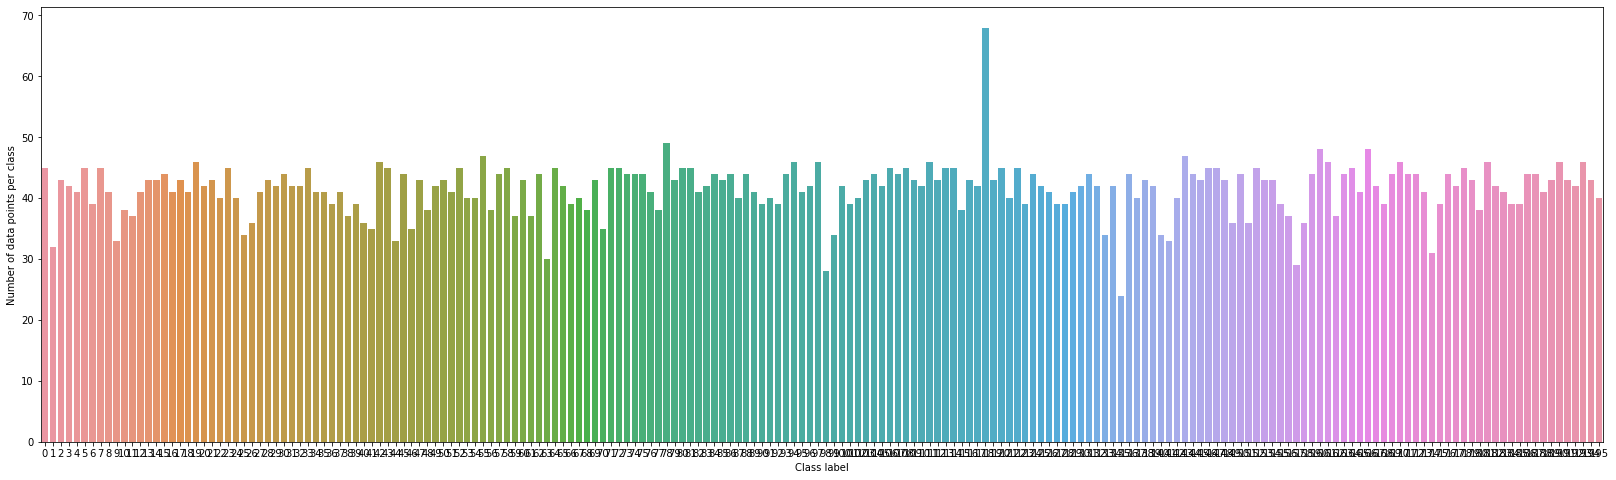

Class with highest number of data ponits : GMC Terrain SUV 2012 (class:118 & counts:68)
Class with lowest number of data ponits  : Hyundai Elantra Sedan 2007 (class:135 & counts:24)


In [ ]:
train_values_counts = train_annot['img_class'].value_counts(sort=False).sort_index()
tr_values = train_values_counts.values

fig = plt.figure(figsize =(28, 8))
sns.barplot(train_values_counts.index - 1, train_values_counts.values)
plt.xlabel('Class label')
plt.ylabel('Number of data points per class')
plt.show()

print(f"Class with highest number of data ponits : {class_map[tr_values.argmax()]} (class:{tr_values.argmax()} & counts:{tr_values.max()})")
print(f"Class with lowest number of data ponits  : {class_map[tr_values.argmin()]} (class:{tr_values.argmin()} & counts:{tr_values.min()})")

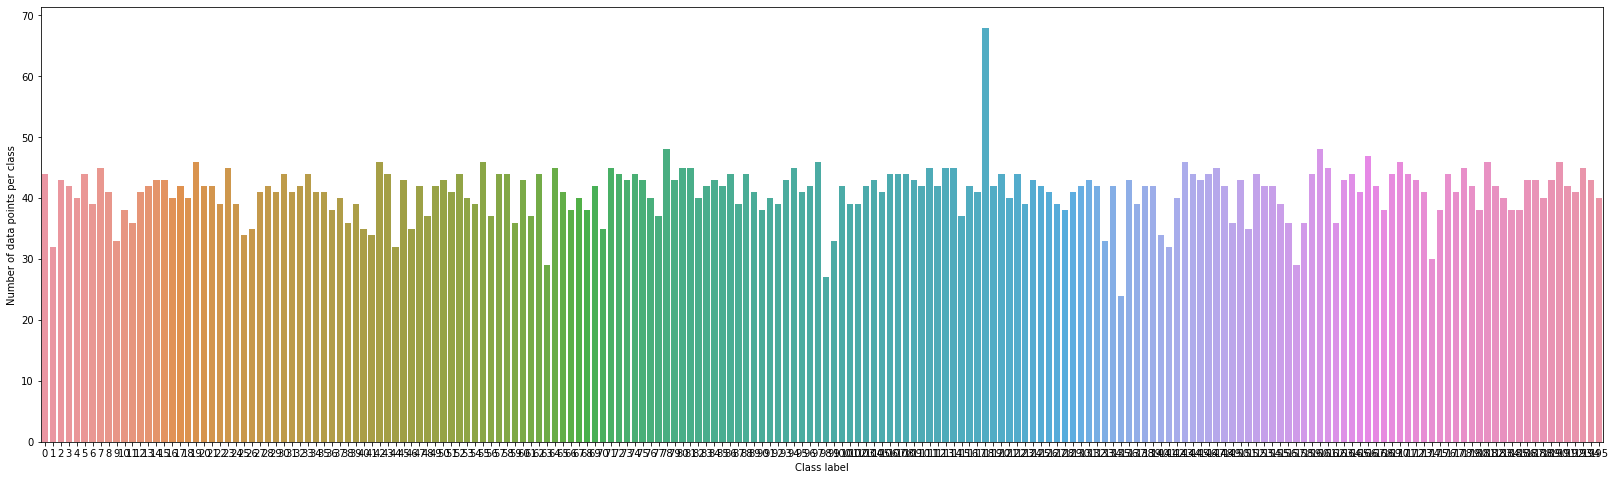

Class with highest number of data ponits : GMC Terrain SUV 2012 (class:118 & counts:68)
Class with lowest number of data ponits  : Hyundai Elantra Sedan 2007 (class:135 & counts:24)


In [ ]:
test_values_counts = test_annot['img_class'].value_counts(sort=False).sort_index()
te_values = test_values_counts.values

fig = plt.figure(figsize =(28, 8))
sns.barplot(test_values_counts.index - 1, test_values_counts.values)
plt.xlabel('Class label')
plt.ylabel('Number of data points per class')
plt.show()

print(f"Class with highest number of data ponits : {class_map[te_values.argmax()]} (class:{te_values.argmax()} & counts:{te_values.max()})")
print(f"Class with lowest number of data ponits  : {class_map[te_values.argmin()]} (class:{te_values.argmin()} & counts:{te_values.min()})")

- Class distribution in train and test data is almost similar

In [ ]:
for i in range(10):
    rand_num = np.random.randint(0,len(train_annot))
    print(cv2.imread(train_merge['file_path'][rand_num]).shape)

(266, 400, 3)
(685, 1023, 3)
(480, 640, 3)
(457, 610, 3)
(2153, 3552, 3)
(240, 350, 3)
(1200, 1600, 3)
(395, 650, 3)
(329, 475, 3)
(187, 300, 3)


- Each images are of different size. So image has to be resized to a common size

In [ ]:
print(f"Train Data :-> Average height : {int(train_height.mean())}  & Average width : {int(train_width.mean())}")
print(f"Test Data  :-> Average height : {int(test_height.mean())}  & Average width : {int(test_width.mean())}")

Train Data :-> Average height : 482  & Average width : 699
Test Data  :-> Average height : 483  & Average width : 701


 - Images in train and test data has similar average heights and widths

In [ ]:
print(f"Train Data :-> Median height : {np.median(train_height)}  & Median width : {np.median(train_height)}")
print(f"Test Data  :-> Median height : {np.median(test_width)}  & Median width : {np.median(test_width)}")

Train Data :-> Median height : 424.0  & Median width : 424.0
Test Data  :-> Median height : 640.0  & Median width : 640.0


 - Images in train and test data has same median heights and widths

In [ ]:
print(f"Train Data :-> STD height : {int(train_height.std())}  & STD width : {int(train_width.std())}")
print(f"Test Data  :-> STD height : {int(test_height.std())}  & STD width : {int(test_width.std())}")

Train Data :-> STD height : 317  & STD width : 450
Test Data  :-> STD height : 319  & STD width : 455


 - Images in train and test data has similar standard deviation in heights and widths

For train data : 


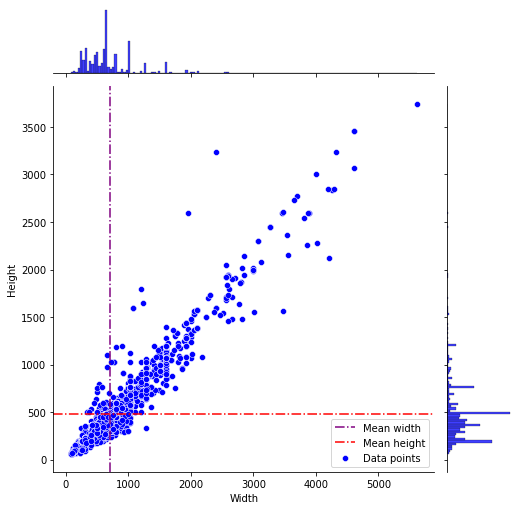

In [ ]:

print("For train data : ")
plot = sns.jointplot(train_width, train_height, height=7, color='blue', label='Data points')
plot.ax_joint.axvline(x=train_width.mean(), linestyle='-.', color='purple', label='Mean width')
plot.ax_joint.axhline(y=train_height.mean(), linestyle='-.', color='red', label='Mean height')
plot.ax_joint.set_xlabel('Width')
plot.ax_joint.set_ylabel('Height')
plot.ax_joint.legend()

For test data : 


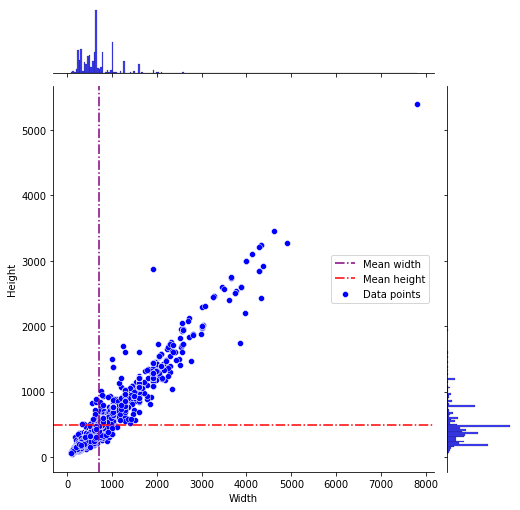

In [ ]:
print("For test data : ")
plot = sns.jointplot(test_width, test_height, height=7, color='blue', label='Data points')
plot.ax_joint.axvline(x=test_width.mean(), linestyle='-.', color='purple', label='Mean width')
plot.ax_joint.axhline(y=test_height.mean(), linestyle='-.', color='red', label='Mean height')
plot.ax_joint.set_xlabel('Width')
plot.ax_joint.set_ylabel('Height')
plot.ax_joint.legend()

# Experimenting with Data Augumentation

## Loading processed annotations file

In [ ]:
val_idx = np.load('/content/drive/MyDrive/Car Images/temp_files/val_index_split.npz')['arr_0']

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Car Images/processed_outputs/train_processed.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Car Images/processed_outputs/test_processed.csv')

train_data.shape, test_data.shape

((8144, 7), (8041, 7))

In [ ]:
train_data['file_path'] = train_data['file_path'].apply(lambda x:x.replace('\\', '/'))
test_data['file_path']  = test_data['file_path'].apply(lambda x:x.replace('\\', '/'))

In [ ]:
train_filepath = train_data['file_path'].values
val_filepath = (test_data['file_path'][val_idx]).values

In [ ]:
train_label = tf.keras.utils.to_categorical(train_data['img_class'].values, num_classes=196)
val_label = np.load('/content/drive/MyDrive/Car Images/temp_files/test_label.npz')['arr_0'][val_idx]

train_height = np.load('/content/drive/MyDrive/Car Images/temp_files/train_height_array.npz')['arr_0']
val_height   = np.load('/content/drive/MyDrive/Car Images/temp_files/test_height_array.npz')['arr_0'][val_idx]

train_width = np.load('/content/drive/MyDrive/Car Images/temp_files/train_width_array.npz')['arr_0']
val_width   = np.load('/content/drive/MyDrive/Car Images/temp_files/test_width_array.npz')['arr_0'][val_idx]

train_bbox = train_data[['x1', 'y1', 'x2', 'y2']].values
val_bbox = test_data[['x1', 'y1', 'x2', 'y2']].values[val_idx]

## Data Augumentation

In [ ]:
# !pip install -U albumentations

import albumentations as A
import cv2

transforms = A.Compose(
    [
    A.HorizontalFlip(p=0.5),
    A.RGBShift(p=0.6),
    A.Rotate(limit=30,p=0.9),
    A.ChannelShuffle(p=.6),
    A.RandomBrightnessContrast()
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category_id"])
)


In [ ]:
def aug_fn(file_path, bounding_box, class_label, img_size):

    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, expand_animations = False, channels=3)
    h, w, _ = img.shape
    x1, y1, x2, y2 = bounding_box
    params = {
        'image' : img.numpy(),
        'bboxes' : [[x1, y1, x2-x1, y2-y1]],
        'category_id' : [class_label]
    }

    aug_data = transforms(**params)
    aug_img  = aug_data["image"]
    aug_bbox = aug_data["bboxes"]

    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    aug_img.set_shape((img_size,img_size,3))
    x_new, y_new, w_new, h_new = aug_bbox[0]
    x_new = x_new*(img_size/w)
    y_new = y_new*(img_size/h)
    w_new = w_new*(img_size/w)
    h_new = h_new*(img_size/h)

    return aug_img.numpy(), (np.array([x_new, y_new, w_new, h_new]), class_label)

In [ ]:
def train_generator():
    for filepath, bbox, label in zip(train_filepath, train_bbox, train_label):
        image, y_variable = aug_fn(filepath, bbox, label, 224)
        yield image, y_variable

In [ ]:
def val_generator():
    for file_path, bbox, label in zip(val_filepath, val_bbox, val_label):
        image = tf.io.read_file(file_path)
        image = tf.io.decode_image(image, expand_animations = False, channels=3)

        IMG_SIZE = 224
        image_resize = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        h, w, _ = image.shape
        x1, y1, x2, y2 = bbox
        x_new = x1*(IMG_SIZE/w)
        y_new = y1*(IMG_SIZE/h)
        w_new = (x2-x1)*(IMG_SIZE/w)
        h_new = (y2-y1)*(IMG_SIZE/h)

        yield image_resize.numpy(), (np.array([x_new, y_new, w_new, h_new]), label)

In [ ]:
a,b = next(train_generator())
print(a.shape, a.dtype)
print(b[0].shape, b[0].dtype)
print(b[1].shape, b[1].dtype)

(224, 224, 3) float32
(4,) float64
(196,) float32


In [ ]:
a,b = next(val_generator())
print(a.shape, a.dtype)
print(b[0].shape, b[0].dtype)
print(b[1].shape, b[1].dtype)

(224, 224, 3) float32
(4,) float64
(196,) float32


## IoU

In [ ]:

def IOU(y_true, y_pred):

    x1, y1, w, h = y_true[:,0], y_true[:,1], y_true[:,2], y_true[:,3]

    x1_pred, y1_pred, w_pred, h_pred = y_pred[:,0], y_pred[:,1], y_pred[:,2], y_pred[:,3]

    diff_width  = np.minimum(x1 + w, x1_pred + w_pred) - np.maximum(x1, x1_pred)
    diff_height = np.minimum(y1 + h, y1_pred + h_pred) - np.maximum(y1, y1_pred)

    intersection = diff_width * diff_height

    area_true = w * h
    area_pred = w_pred * h_pred

    union = area_true + area_pred - intersection

    intersection_sum = 0
    union_sum = 0

     # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersection_sum += intersection[j]
            union_sum += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersection_sum / (union_sum + tf.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou


import tensorflow as tf
def IoU(y_true, y_pred):

    iou = tf.py_function(IOU, [y_true, y_pred], Tout=tf.float32)
    return iou

## MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

mobile_net = MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False, alpha=1)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# for layer in mobile_net.layers[0:len(mobile_net.layers)-31]:
#     layer.trainable = False

In [ ]:
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
pre_process = preprocess_input(inputs)
x = mobile_net(pre_process)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
class_out = Dense(196, activation='softmax', name='class_output')(x)

# bbox_1 = Dense(512, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform')(x)
bbox_out = Dense(4, name='box_output')(x)

mobile_net_combi = tf.keras.Model(inputs=inputs, outputs=[bbox_out, class_out])
mobile_net_combi.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, 7, 7, 1024)  3228864     ['tf.math.subtract[0][0]']   

In [ ]:
# Fit the model

history2 = mobile_net_combi.fit(train_loader,
                           epochs=20,
                           batch_size=32,
                           validation_data=val_loader,
                           callbacks = callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
    255/Unknown - 189s 664ms/step - loss: 94.4580 - box_output_loss: 51.5466 - class_output_loss: 4.2911 - box_output_IoU: 0.3518 - class_output_accuracy: 0.1316
Epoch 1: val_class_output_accuracy improved from -inf to 0.17437, saving model to /content/drive/MyDrive/Car Images/model/mobile_net_combi_with_aug.hdf5
255/255 [==============================] - 204s 723ms/step - loss: 94.4580 - box_output_loss: 51.5466 - class_output_loss: 4.2911 - box_output_IoU: 0.3518 - class_output_accuracy: 0.1316 - val_loss: 55.9143 - val_box_output_loss: 17.6627 - val_class_output_loss: 3.8252 - val_box_output_IoU: 0.7005 - val_class_output_accuracy: 0.1744 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
255/255 [==============================] - ETA: 0s - loss: 32.9625 - box_output_loss: 10.9277 - class_output_loss: 2.2035 - box_output_IoU: 0.8212 - class_

In [ ]:
mobile_net_combi.save('/content/drive/MyDrive/Car Images/model/mobile_net')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car Images/model/mobile_net_combi_with_aug/assets


In [ ]:
def plot_model_training(history):
    train_acc = history.history['IoU']
    test_acc = history.history['val_IoU']

    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    learning_rate = history.history['lr']

    plt.figure(figsize=(6,12))

    ax1 = plt.subplot(311)
    plt.plot(train_loss, label='train')
    plt.plot(test_loss, label='test')
    plt.legend()
    plt.grid()
    # plt.xlabel('epoch number')
    plt.ylabel('Loss')
    plt.title('Change of loss over epoch')


    ax2 = plt.subplot(312, sharex = ax1)
    plt.plot(train_acc, label='train')
    plt.plot(test_acc, label='test')
    plt.legend()
    plt.grid()
    # plt.xlabel('epoch number')
    plt.ylabel('IoU')
    plt.title('Change of IoU over epoch')

    ax3 = plt.subplot(313, sharex = ax1)
    plt.plot(learning_rate, label='learning rate')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch number')
    plt.ylabel('Learning Rate')
    plt.title('Change of Learning rate over epoch')
    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.2)#, top=0.9, wspace=0.4, hspace=0.4, right=1.5)

    plt.show()

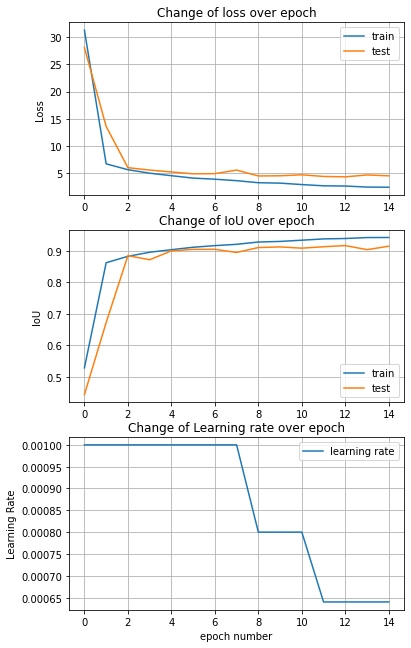

In [ ]:
plot_model_training(history)